

# **La Décalcomanie, 1966 by Rene Magritte**



![Transfer](https://raw.githubusercontent.com/asyaf/magritte/master/images/transfer.jpg)

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import cv2
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

In [0]:
IMG_PATH = "drive/My Drive/Data/magritte data"
MAN_IMG = "man2.jpg"
MAN_IMG_PATH = os.path.join(IMG_PATH, MAN_IMG)
CURTAIN_IMG = "curtain.jpg"
CURTAIN_IMG_PATH = os.path.join(IMG_PATH, CURTAIN_IMG)
SEA_IMG = "sea.jpg"
SEA_IMG_PATH = os.path.join(IMG_PATH, SEA_IMG)

# Utils

In [0]:
def load_image(path):
  image = cv2.imread(path)
  return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def mask_to_gray(mask):
  return np.array(mask).astype(np.uint8)*255

def trim_image(img, min_x, max_x, min_y, max_y):
  return img[min_y:max_y, min_x:max_x]

def is_gray(img):
  # gray images have either 1 channel or R = G = B
  if len(img.shape) > 2:
    channels = cv2.split(img)
    if np.array_equal(channels[0], channels[1]) \
      and np.array_equal(channels[0], channels[2]):
      return True
    else:
      return False
  else:
    return True

def display_image(img):
    if is_gray(img):
      plt.imshow(img, cmap="gray")
    else:
      plt.imshow(img)
    plt.show()

def display_images(imgs):
  if len(imgs) == 1:
    display_image(imgs[0])
    return 
  fig, axs = plt.subplots(1, len(imgs))
  for ax, img in zip(axs, imgs):
    if is_gray(img):
      ax.imshow(img, cmap="gray")
    else:
      ax.imshow(img)
  plt.show()

def rotate_image(image, angle):
  """
  Args:
    Image
    Angle - in degrees

  Returns:
    Image rotated by angle
  """
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def alpha_blend(foreground, background, alpha):
  """
  Args:
    foreground - image to be blended in
    background - image to be blended on
    alpha - mask image
  
  Returns:
    Alpha blended image, with float values

  Assumptions:
    Images have same dimension
  """

  # convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)
 
  # normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)
 
  # multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)
 
  # add the masked foreground and background.
  out = cv2.add(foreground, background)
  return out

def resize_image(img, width, height):
  return cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)

def paste_image_with_offset(large_img, small_img, x_offset, y_offset):
  """
  Args:
    large image - image to paste on
    small image - image to paste
    x_offset, y_offset - offsets in pixels for pasting

  Returns:
    Large image with pasted small image on top

  Assumptions:
    Number of channels of images coincide
    Pasted image is small enough to be pasted with required offset
  """
  img_copy = large_img.copy()
  small_h, small_w = small_img.shape[0], small_img.shape[1]
  img_copy[y_offset:y_offset+small_h, x_offset:x_offset+small_w] = small_img
  return img_copy

# Load Mask R-CNN

Use of pre-trained Mask R-CNN model to detect and segment objects.

(code taken from demo)

In [5]:
!git clone 'https://github.com/matterport/Mask_RCNN.git'

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [6]:
# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. 

In [7]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [8]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








## Class Names

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (368, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


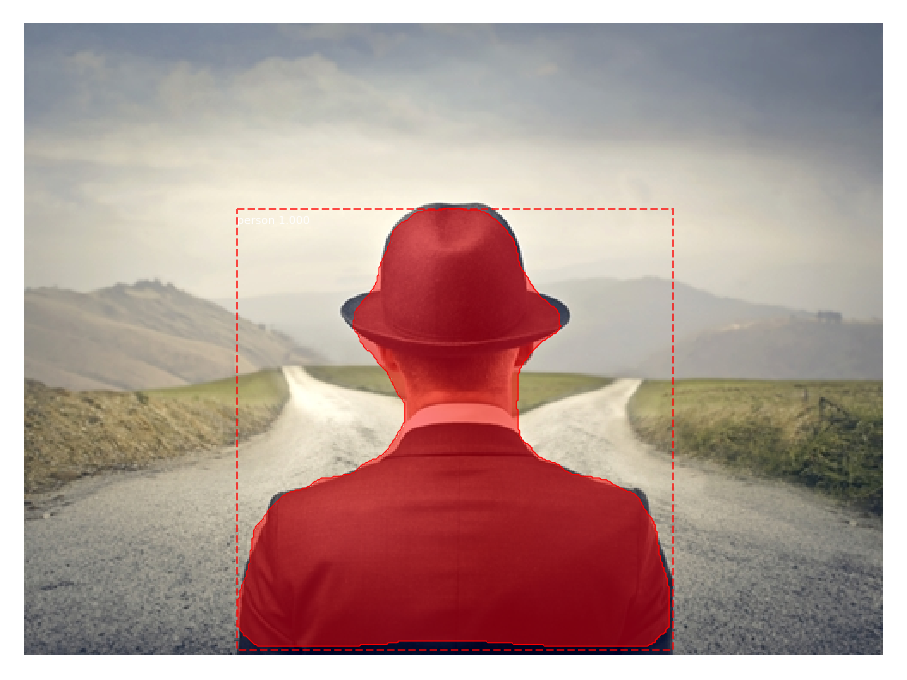

In [10]:
man_img = load_image(MAN_IMG_PATH)

# Run detection
results = model.detect([man_img], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(man_img, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Extract man figure

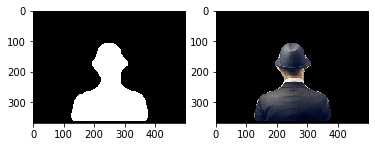

In [11]:
man_mask = mask_to_gray(r['masks'][:,:,0])
extracted_man_img = cv2.copyTo(man_img, man_mask)
img_list = [man_mask, extracted_man_img]
display_images(img_list)

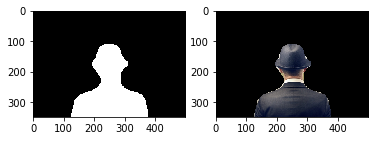

In [12]:
h, w, _ = extracted_man_img.shape

min_x = 0
max_x = w
min_y = 0
max_y = h - 20

trimmed_man_mask = trim_image(man_mask, min_x, max_x, min_y, max_y)
trimmed_extracted_man_img = trim_image(extracted_man_img, min_x, max_x, min_y, max_y)
display_images([trimmed_man_mask, trimmed_extracted_man_img])

# Handle curtain

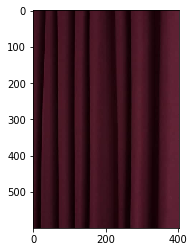

In [13]:
curtain_img = load_image(CURTAIN_IMG_PATH)
display_image(curtain_img)

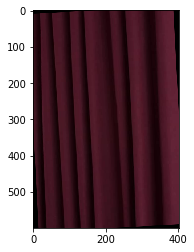

In [14]:
rot_angle = 3
rotated_curtain_img = rotate_image(curtain_img, rot_angle)
display_image(rotated_curtain_img)

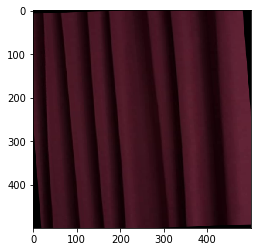

In [15]:
new_curtain_w, new_curtain_h = 500, 500
resized_curtain_img = resize_image(rotated_curtain_img, new_curtain_w, new_curtain_h)
display_image(resized_curtain_img)

# Handle sea

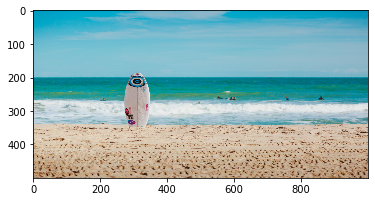

In [16]:
sea_img = load_image(SEA_IMG_PATH)
# new_sea_w, new_sea_h = padded_man_img.shape[0] * 2, padded_man_img.shape[1]
new_sea_w, new_sea_h = new_curtain_w * 2, new_curtain_h
resized_sea_img = resize_image(sea_img, new_sea_w, new_sea_h)
display_image(resized_sea_img)

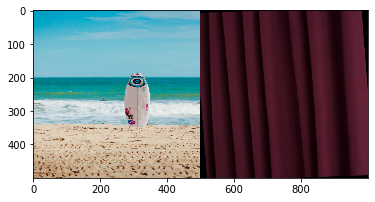

In [17]:
curtain_x_offset = new_curtain_w
sea_curtain_img = paste_image_with_offset(resized_sea_img, resized_curtain_img, 
                          curtain_x_offset, 0)
display_image(sea_curtain_img)

# Blend man image

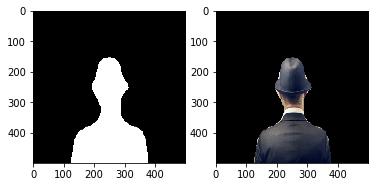

In [18]:
resized_man_img = resize_image(trimmed_extracted_man_img, new_curtain_w, new_curtain_h)
resized_man_mask = resize_image(trimmed_man_mask, new_curtain_w, new_curtain_h)
img_list = [resized_man_mask, resized_man_img]
display_images(img_list)

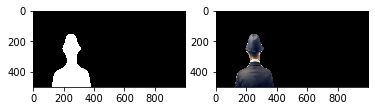

In [19]:
empty_img = np.zeros(sea_curtain_img.shape, dtype=np.uint8)
man_x_offset = 0
man_y_offset = 0
padded_man_img = paste_image_with_offset(empty_img, resized_man_img, 
                                         man_x_offset, man_y_offset)
rgb_man_mask = cv2.cvtColor(resized_man_mask, cv2.COLOR_GRAY2RGB)
padded_man_mask = paste_image_with_offset(empty_img, rgb_man_mask, 
                                         man_x_offset, man_y_offset)
img_list = [padded_man_mask, padded_man_img]
display_images(img_list)

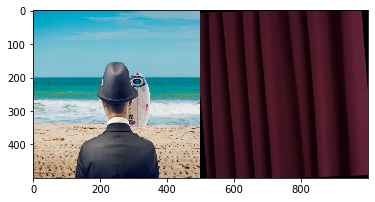

In [20]:
man_sea_curtain_img = alpha_blend(padded_man_img, sea_curtain_img, padded_man_mask)
man_sea_curtain_img = man_sea_curtain_img.astype(np.uint8)
display_image(man_sea_curtain_img)

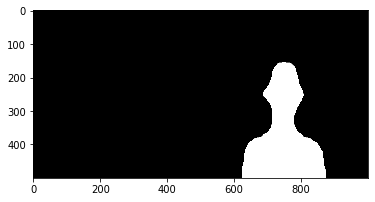

In [21]:
mirrored_padded_man_mask = cv2.flip(padded_man_mask, 1)
display_image(mirrored_padded_man_mask)

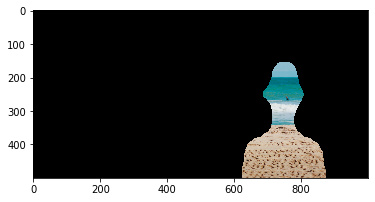

In [22]:
extracted_sea_img = cv2.copyTo(resized_sea_img, mirrored_padded_man_mask)
display_image(extracted_sea_img)

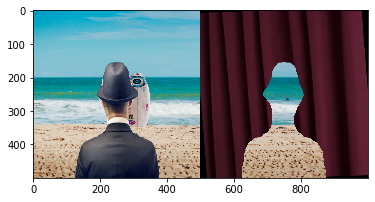

In [23]:
res_img = alpha_blend(extracted_sea_img, man_sea_curtain_img, mirrored_padded_man_mask)
res_img = res_img.astype(np.uint8)
display_image(res_img)